# Modelling

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

from utils.classification_helpers import combine_orbit_predictions
from utils.validation_helpers import evaluate_with_3x3_window

In [12]:
# Load final dataset
final_df = pd.read_csv('../data/processed/final/final_data.csv')

# Remove rows where ref_min is -70
final_df = final_df[final_df['ref_VV_min'] != -70]

In [13]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split

# Split by pixel_id, not by individual rows
# get unique pixel_ids
unique_pixels = final_df['pixel_id'].unique()

train_pixels, test_pixels = train_test_split(
    unique_pixels, 
    test_size=0.2,
    random_state=42
)

# Now create train and test dataframes based on pixel_ids
train_features = final_df[final_df['pixel_id'].isin(train_pixels)]
test_features = final_df[final_df['pixel_id'].isin(test_pixels)]

print(f"Training set: {len(train_features)} rows, {train_pixels.shape[0]} unique pixels")
print(f"Testing set: {len(test_features)} rows, {test_pixels.shape[0]} unique pixels")


Training set: 12444 rows, 7679 unique pixels
Testing set: 3126 rows, 1920 unique pixels


In [ ]:
# Step 4: Train a classifier (example using Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Select feature columns (excluding identifiers and labels)
feature_cols = [col for col in train_features.columns 
                if (col.startswith(('ref_', 'assess_')) and 
                    not col.endswith('_count'))]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_features[feature_cols])
X_test = scaler.transform(test_features[feature_cols])

y_train = train_features['is_damaged']
y_test = test_features['is_damaged']

In [19]:
# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Make predictions
test_features['damage_prob'] = clf.predict_proba(X_test)[:, 1]

/var/folders/r4/hzh5vjhs64sfqz3fgg0md4x80000gn/T/ipykernel_15438/54993745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['damage_prob'] = clf.predict_proba(X_test)[:, 1]


In [34]:
# Combine predictions from different orbits
pixel_predictions = test_features.groupby('pixel_id')[['damage_prob', 'is_damaged', 'point_id', 'point_lon', 'point_lat']].mean()
pixel_predictions["damage_pred"] = (pixel_predictions['damage_prob'] > 0.5).astype(int)

              precision    recall  f1-score   support

         0.0       0.53      0.52      0.53       943
         1.0       0.55      0.56      0.55       977

    accuracy                           0.54      1920
   macro avg       0.54      0.54      0.54      1920
weighted avg       0.54      0.54      0.54      1920



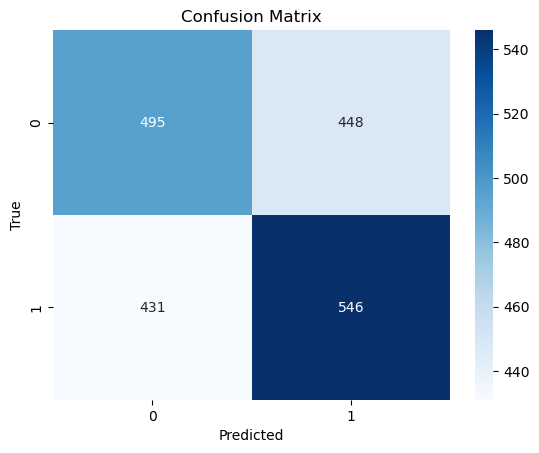

In [35]:
# Evaluate model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Classification report
print(classification_report(pixel_predictions['is_damaged'], pixel_predictions['damage_pred']))
# Confusion matrix
cm = confusion_matrix(pixel_predictions['is_damaged'], pixel_predictions['damage_pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
pixel_predictions_gdf = gpd.GeoDataFrame(
    pixel_predictions.reset_index(),
    geometry=gpd.points_from_xy(pixel_predictions['point_lon'], pixel_predictions['point_lat']),
    crs="EPSG:4326"  # Adjust to match your data's CRS
)

# Save predictions to GeoDataFrame
pixel_predictions_gdf.to_file('../results/predictions/predictions.geojson', driver='GeoJSON')